In [12]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from dynamics import *
from plotting import *
from computation import *
from networkParameters import *
import matplotlib.pyplot as plt


In [13]:

test_loading_of_system = False

if test_loading_of_system is True:
    number_of_patterns = 1 
else:
    number_of_patterns = 2
# generate network settings
internal_weights = np.random.standard_normal(size=(N, N))
input_weights = np.random.normal(0, 1, size=(N))
output_weights = np.random.normal(0, 1, size=(N)).transpose()
leaking_matrix = np.identity(N)*a_internal
bias_vector = np.random.normal(0, 1, size=(N))

In [47]:

def plot_aperture(training_data, internal_weights_computed, leaking_matrix=None, output_weights_used=None, input_signal=2*np.sin(t/20)):
    aperture_values = [1, 60, 200, 10000]

    negation_data_output = []
    no_control_data_output = []
    quotes = []
    for alpha in aperture_values:
        conceptor = compute_conceptor(training_data, alpha)
        quotes.append(compute_conceptor_quota(conceptor))
        # Test conceptor retrieval, use conceptor in update loop.
        parameters_test_conceptor = (tau, leaking_matrix, internal_weights_computed, conceptor)

        negation_data = odeint(leaky_esn_conceptor_negation, np.random.standard_normal(N), t, parameters_test_conceptor)
        no_control_data = odeint(leaky_esn_no_control, np.random.standard_normal(N), t, parameters_test_conceptor)

        negation_point = []
        no_control_point = []

        for step_number in range(len(negation_data)):
            negation_point.append(np.dot(output_weights_used, negation_data[step_number]))
            no_control_point.append(np.dot(output_weights_used, no_control_data[step_number]))

        negation_data_output.append(negation_point)
        no_control_data_output.append(no_control_point)

    fig, axs = plt.subplots(2, 2)

    idx = 0
    right = 0
    axs[idx][right].set_title(f"alpha= {aperture_values[idx]} quota = {quotes[idx]}")
    axs[idx][right].plot(t, negation_data_output[idx], label="negation", color='red')
    axs[idx][right].plot(t, no_control_data_output[idx], label="no control", color='green')
    axs[idx][right].plot(t, input_signal, label="input signal", color='blue')

    right = 1
    axs[idx][right].set_title(f"alpha= {aperture_values[1]} quota = {quotes[1]}")
    axs[idx][right].plot(t, negation_data_output[1], label="negation", color='red')
    axs[idx][right].plot(t, no_control_data_output[1], label="no control", color='green')
    axs[idx][right].plot(t, input_signal, label="input signal", color='blue')

    right = 0
    idx = 1
    axs[idx][right].set_title(f"alpha= {aperture_values[2]} quota = {quotes[2]}")
    axs[idx][right].plot(t, negation_data_output[2], label="negation", color='red')
    axs[idx][right].plot(t, input_signal, label="input signal", color='blue')
    axs[idx][right].plot(t, no_control_data_output[2], label="no control", color='green')

    right = 1
    axs[idx][right].set_title(f"alpha= {aperture_values[3]} quota = {quotes[3]}")
    axs[idx][right].plot(t, negation_data_output[3], label="negation", color='red')
    axs[idx][right].plot(t, input_signal, label="input signal", color="blue")
    axs[idx][right].plot(t, no_control_data_output[3], label="no control", color="green")


    print(quotes)
    plt.legend()
    plt.show()
    


In [15]:

def conceptor_retrieval(conceptors, leaking_matrix, internal_weights_computed, output_weights):
    for i in range(number_of_patterns):
        conceptor = conceptors[i]
        parameters_test_conceptor = (tau, leaking_matrix, internal_weights_computed, conceptor)
        initial_condition = np.random.standard_normal(N)
        y_test_conceptor_negation = odeint(leaky_esn_conceptor_negation, initial_condition, t, parameters_test_conceptor)
        y_test_conceptor_no_control = odeint(leaky_esn_no_control, initial_condition, t, parameters_test_conceptor)

        plot_states_with_output(y_test_conceptor_negation, output_weights, get_input(i, t), "plot with control")
        plot_states_with_output(y_test_conceptor_no_control, output_weights, get_input(i, t), "plot without control")
    # plot_control_errors(6)


In [16]:
def test_loading(leaking_matrix, internal_weights_computed, output_weights_computed):
    # Test the loading. Use loaded reservoir and signal input, no conceptor
    parameters_test_system = (tau, leaking_matrix, internal_weights_computed)
    initial_condition_loading = state_matrix[:, 500]
    y_test_system_loading = odeint(test_loading, initial_condition_loading, t, parameters_test_system)
    plot_liquid_states(y_test_system_loading, f'Liquid states loading, reguliser {regularisation_internal}')
    plot_output(y_test_system_loading, output_weights_computed, f'loading testing output, reguliser {regularisation_internal}')

In [17]:

# scale internal weights
eigenvalues = eigvals(internal_weights)
scaling_factor = max(abs(eigenvalues))
print(scaling_factor)
internal_weights *= desired_spectral_radius/scaling_factor

10.674946552677506


In [18]:

training_data = []
for i in range(number_of_patterns):
    parameters_training = (tau, leaking_matrix, internal_weights, input_weights, i)
    y_training = odeint(leaky_esn, np.random.standard_normal(N), t, parameters_training)
    training_data.append(y_training)


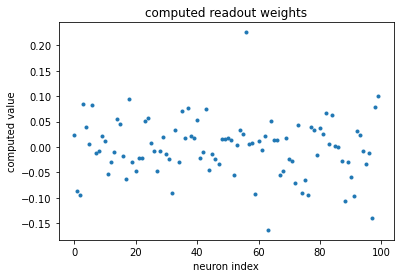

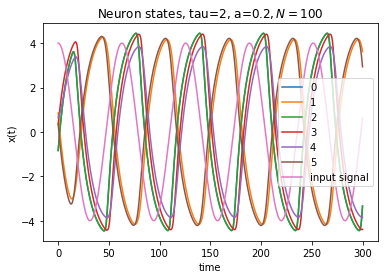

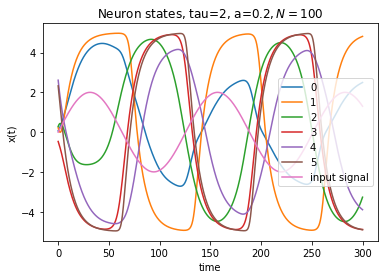

In [19]:

# prepare the conceptor and load the patterns
output_weights_computed = compute_output_weights(training_data)
plot_neuron_states(training_data)

In [20]:

test_data_output = []
for i in range(number_of_patterns):
    parameters_training = (tau, leaking_matrix, internal_weights, input_weights, i)
    y_training = odeint(leaky_esn, np.random.standard_normal(N), t, parameters_training)
    test_data_output.append(y_training)

In [21]:

regularisation_internal = 10
internal_weights_computed = compute_loading_weights(training_data, regularisation_internal)

In [22]:
if test_loading_of_system:
    test_loading()

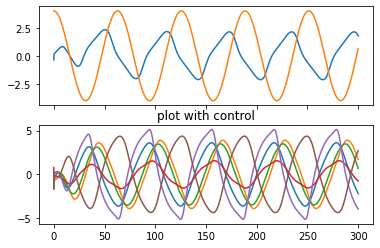

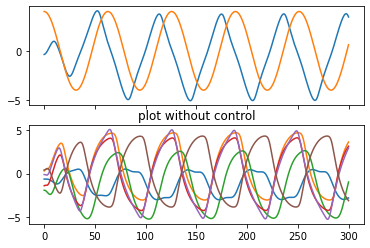

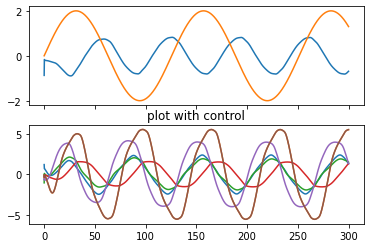

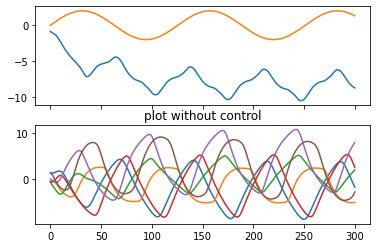

In [23]:
aperture = 6000
conceptors = compute_conceptors(training_data, aperture)

# Test conceptor retrieval
conceptor_retrieval(conceptors, leaking_matrix, internal_weights_computed, output_weights_computed)
# plot_aperture_response(y_training, internal_weights_computed, P, leaking_matrix, output_weights_computed)


[0.02524461008959931, 0.09008598981790689, 0.11825830677732668, 0.23776362965199138]


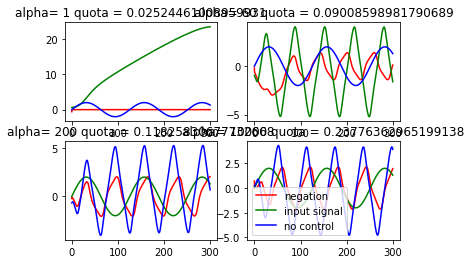

[0.0302631628716041, 0.11242177519304589, 0.1561208606861724, 0.32392306580613517]


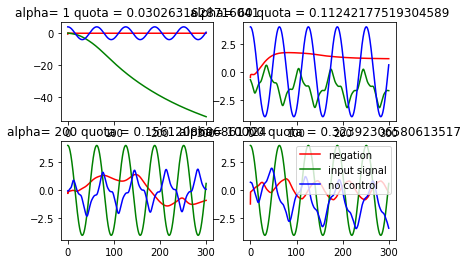

In [48]:

for idx, signal in enumerate(training_data):
    plot_aperture(signal, internal_weights_computed, leaking_matrix, output_weights_computed, get_input(idx+1, t))
